In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier

In [2]:
#df=pd.read_csv('https://raw.githubusercontent.com/ashishktripathi/Credit-Card-Approval/master/CC_data.csv')
#df.to_csv('CC_data')
df=pd.read_csv('CC_data')
print(df.columns)
df['Approved']=[1 if x=="+" else 0 for x in df['Approved']]
encoder = LabelEncoder()
df['Male']=encoder.fit_transform(df['Male'])
df['Married']=encoder.fit_transform(df['Married'])
df['Employed']=encoder.fit_transform(df['Employed'])
df['PriorDefault']=encoder.fit_transform(df['PriorDefault'])
df['Citizen']=encoder.fit_transform(df['Citizen'])
df['DriversLicense']=encoder.fit_transform(df['DriversLicense'])
df['BankCustomer']=encoder.fit_transform(df['BankCustomer'])
df['EducationLevel']=encoder.fit_transform(df['EducationLevel'])
df['ZipCode']=pd.to_numeric(df['ZipCode'],errors='coerce').fillna(0)
df['Age']=pd.to_numeric(df['Age'],errors='coerce').fillna(0)
ohe=pd.get_dummies(df['Ethnicity'],prefix="ethnicity_")
df=pd.concat([df,ohe],axis=1)
df=df.drop('Ethnicity',axis=1)
NUMERIC=[ column for column in df.columns if np.issubdtype(df[column],np.number) ]
TEXT=[ column for column in df.columns if np.issubdtype(df[column],np.number)==False ]
print(NUMERIC,TEXT)

#print(df['ZipCode'])

Index(['Unnamed: 0', 'Male', 'Age', 'Debt', 'Married', 'BankCustomer',
       'EducationLevel', 'Ethnicity', 'YearsEmployed', 'PriorDefault',
       'Employed', 'CreditScore', 'DriversLicense', 'Citizen', 'ZipCode',
       'Income', 'Approved'],
      dtype='object')
['Unnamed: 0', 'Male', 'Age', 'Debt', 'Married', 'BankCustomer', 'EducationLevel', 'YearsEmployed', 'PriorDefault', 'Employed', 'CreditScore', 'DriversLicense', 'Citizen', 'ZipCode', 'Income', 'Approved', 'ethnicity__?', 'ethnicity__bb', 'ethnicity__dd', 'ethnicity__ff', 'ethnicity__h', 'ethnicity__j', 'ethnicity__n', 'ethnicity__o', 'ethnicity__v', 'ethnicity__z'] []


In [3]:
X=df[[x for x in NUMERIC if x!='Approved']]
y=df['Approved']

#print(len(NUMERIC))
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.4,random_state=42)

pipeline= Pipeline([
    ('scaler',StandardScaler()),
    #('pca', PCA()),
    ('clf',LogisticRegression(C=5,max_iter=10000, tol=0.1)),
#('clf',MLPClassifier(hidden_layer_sizes=(25,150,25),  max_iter=800, solver='lbfgs', activation='relu', alpha=0.7, 
#                 learning_rate_init=0.001,  verbose=False, momentum=0.9, random_state=42))
])

pipeline.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', LogisticRegression(C=5, max_iter=10000, tol=0.1))])

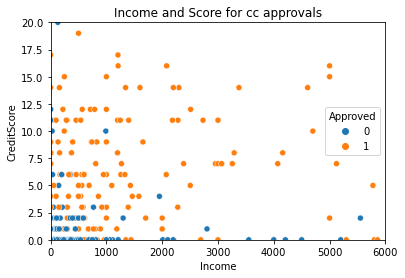

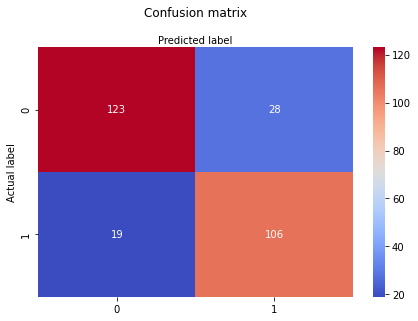

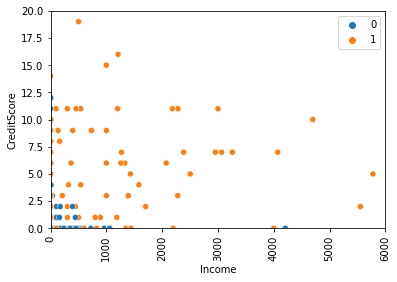

In [4]:
sns.scatterplot(x='Income',y='CreditScore',hue='Approved', data=df)
plt.title("Income and Score for cc approvals")
plt.xlim(0, 6000)
plt.ylim(0,20)
plt.show()

y_pred=pipeline.predict(X_test)

cm = confusion_matrix(y_test,y_pred)

class_names=[1,2]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="coolwarm" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()


pred= y_pred.flatten()
hue=pred
#print(hue)
#print(np.sum(hue))
sns.scatterplot(x=X_test['Income'],y=X_test['CreditScore'],hue=hue)
plt.xlim(0, 6000)
plt.ylim(0,20)
plt.xticks(rotation=90)
plt.show()

In [5]:
#parameter_grid={'alpha':np.linspace(0.1,1,5),'momentum':np.linspace(0.1,1,5)}
parameter_grid={'C':np.linspace(5,100,5)}
grid_rf_class=GridSearchCV(
    estimator=pipeline['clf'],
    param_grid=parameter_grid,
    scoring='roc_auc',
    n_jobs=2,
    cv=5,
    refit=True,
    return_train_score=True)

grid_rf_class.fit(X_train,y_train)
predictions=grid_rf_class.predict(X_test)

print(accuracy_score(y_test,predictions));
print(grid_rf_class.best_params_)
print(grid_rf_class.best_score_)

0.8333333333333334
{'C': 5.0}
0.9254684379106211


In [ ]:
pipeline2= Pipeline([
    ('scaler',StandardScaler()),
    ('clf',RandomForestClassifier(n_estimators=62,max_depth=16)),
])

#pipeline2.fit(X_train,y_train)
#
param_grid = {'n_estimators': list(range(30,100)), 'max_depth': list(range(5,26)), 'max_features': ['auto' , 'sqrt']} 

random_rf_class = RandomizedSearchCV(
    estimator = pipeline2['clf'],
    param_distributions= param_grid,
    n_iter = 10,
    scoring='accuracy', n_jobs=2, cv = 10, refit=True, return_train_score = True)

random_rf_class.fit(X_train,y_train)

predictions=random_rf_class.predict(X_test)

print("Model accuracy {}%".format(accuracy_score(y_test,predictions)*100))

# Print the values used for both hyperparameters
print(random_rf_class.cv_results_['param_max_depth'])
print(random_rf_class.cv_results_['param_max_features'])

print(random_rf_class.best_params_)
print(random_rf_class.best_score_)